In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICE"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 사용 패키지

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
from datetime import datetime

In [3]:
now = datetime.now()

print("현재: ", now)
print('Device: ' + torch.cuda.get_device_name(0))
print("CUDA Version: " + torch.version.cuda)

현재:  2023-05-02 10:54:23.353698
Device: NVIDIA GeForce RTX 3060
CUDA Version: 11.6


# 데이터 불러오기

In [4]:
bpath = r'E:\221226_resv2\data\bins4'
path1 = bpath + 'm'
path2 = bpath + 'r'
path3 = bpath + 'b' 
resv2_path = r'E:\221226_resv2'

train_len = range(819)
test_len = range(205)

tr_0 = [[bpath + r'\train\train' + '{:06d}_img'.format(i) for i in train_len],
    [bpath + r'\train\train' + '{:06d}_met'.format(i) for i in train_len],
    [bpath + r'\train\train' + '{:06d}_lab'.format(i) for i in train_len],
    [bpath + r'\train\train' + '{:06d}_ind'.format(i) for i in train_len]
]

tr_1 = [[path1 + r'\train\train' + '{:06d}_img'.format(i) for i in train_len],
    [path1 + r'\train\train' + '{:06d}_met'.format(i) for i in train_len],
    [path1 + r'\train\train' + '{:06d}_lab'.format(i) for i in train_len],
    [path1 + r'\train\train' + '{:06d}_ind'.format(i) for i in train_len]
]

tr_2 = [[path2 + r'\train\train' + '{:06d}_img'.format(i) for i in train_len],
    [path2 + r'\train\train' + '{:06d}_met'.format(i) for i in train_len],
    [path2 + r'\train\train' + '{:06d}_lab'.format(i) for i in train_len],
    [path2 + r'\train\train' + '{:06d}_ind'.format(i) for i in train_len]
]

tr_3 = [[path3 + r'\train\train' + '{:06d}_img'.format(i) for i in train_len],
    [path3 + r'\train\train' + '{:06d}_met'.format(i) for i in train_len],
    [path3 + r'\train\train' + '{:06d}_lab'.format(i) for i in train_len],
    [path3 + r'\train\train' + '{:06d}_ind'.format(i) for i in train_len]
]
trl = [tr_0, tr_1, tr_2, tr_3]

te_0 = [[bpath + r'\test\test' + '{:06d}_img'.format(i) for i in test_len],
    [bpath + r'\test\test' + '{:06d}_met'.format(i) for i in test_len],
    [bpath + r'\test\test' + '{:06d}_lab'.format(i) for i in test_len],
    [bpath + r'\test\test' + '{:06d}_ind'.format(i) for i in test_len]
]

te_1 = [[path1 + r'\test\test' + '{:06d}_img'.format(i) for i in test_len],
    [path1 + r'\test\test' + '{:06d}_met'.format(i) for i in test_len],
    [path1 + r'\test\test' + '{:06d}_lab'.format(i) for i in test_len],
    [path1 + r'\test\test' + '{:06d}_ind'.format(i) for i in test_len]
]

te_2 = [[path2 + r'\test\test' + '{:06d}_img'.format(i) for i in test_len],
    [path2 + r'\test\test' + '{:06d}_met'.format(i) for i in test_len],
    [path2 + r'\test\test' + '{:06d}_lab'.format(i) for i in test_len],
    [path2 + r'\test\test' + '{:06d}_ind'.format(i) for i in test_len]
]

te_3 = [[path3 + r'\test\test' + '{:06d}_img'.format(i) for i in test_len],
    [path3 + r'\test\test' + '{:06d}_met'.format(i) for i in test_len],
    [path3 + r'\test\test' + '{:06d}_lab'.format(i) for i in test_len],
    [path3 + r'\test\test' + '{:06d}_ind'.format(i) for i in test_len]
]
tel = [te_0, te_1, te_2, te_3]

# 데이터 로드

In [5]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, met_dir, lab_dir, ind_dir):
        self.img_dir = img_dir
        self.met_dir = met_dir
        self.lab_dir = lab_dir
        self.ind_dir = ind_dir

    def __len__(self):
        return len(self.lab_dir)
    
    def __getitem__(self, i):
        img = torch.load(self.img_dir[i])
        # met = torch.load(self.met_dir[i])
        lab = torch.load(self.lab_dir[i])
        ind = torch.load(self.ind_dir[i])

        return {
            'img' : img,
            # 'metadata' : met,
            'labels' : lab,
            'indices' : ind
        }


# 하이퍼파라미터 및 변수

In [6]:
device = torch.device("cuda:0")
batch_size = 256
meta_n = 15
learning_rate = 2e-4
class_n = 2
dropout_rate = 0.25
epochs = 100
best_save_path = 'best_model.pt'
shallow = False
imbalanced_weight = True

torch.cuda.max_split_size_mb = 512

print('Batch Size : {:d}'.format(batch_size))
print('Metadata Dimension : {:d}'.format(meta_n))
print('Weight Mode : ' + ('Imbalanced' if imbalanced_weight else 'Uniform'))

Batch Size : 256
Metadata Dimension : 15
Weight Mode : Imbalanced


# 데이터셋 구성

In [7]:
tr = [LoadDataset(tr_0[0], tr_0[1], tr_0[2], tr_0[3]),
    LoadDataset(tr_1[0], tr_1[1], tr_3[2], tr_3[3]),
    LoadDataset(tr_2[0], tr_2[1], tr_2[2], tr_2[3]),
    LoadDataset(tr_3[0], tr_3[1], tr_3[2], tr_3[3])
]
te = [LoadDataset(te_0[0], te_0[1], te_0[2], te_0[3]),
    LoadDataset(te_1[0], te_1[1], te_3[2], te_3[3]),
    LoadDataset(te_2[0], te_2[1], te_2[2], te_2[3]),
    LoadDataset(te_3[0], te_3[1], te_3[2], te_3[3])
]

wholequote = '''
train_dataloader = [DataLoader(tr[0], num_workers=0, shuffle=True),
    DataLoader(tr[1], num_workers=0, shuffle=True),
    DataLoader(tr[2], num_workers=0, shuffle=True),
    DataLoader(tr[3], num_workers=0, shuffle=True)
]

test_dataloader = [DataLoader(te[0], num_workers=0, shuffle=False),
    DataLoader(te[1], num_workers=0, shuffle=False),
    DataLoader(te[2], num_workers=0, shuffle=False),
    DataLoader(te[3], num_workers=0, shuffle=False)
]'''

# 모델

## 이미지 분류 모델 : MobileNet-64

In [8]:
class MobileNet64(nn.Module):
    def __init__(self, class_n, dropout_rate = 0.5, width_mult=1.0, res_mult=1.0, shallow=False):
        super(MobileNet64, self).__init__()
        self.width_mult = width_mult
        self.res_mult = res_mult
        self.class_n = class_n
        self.rate = dropout_rate
        # self.meta_hidden = [200, 200]
        self.conv1 = self._conv(2, self._apply_mult(32), 3, 1)
        self.dropout = nn.Dropout(dropout_rate)
        if shallow is False:
            self.channels = [32, 64, 128, 128, 256,
                             256, 512, 512, 512, 512, 512, 512, 1024, 1024]
            self.stride = [1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1]
        else:
            self.channels = [32, 64, 128, 128, 256,
                             256, 512, 1024, 1024]
            self.stride = [1, 2, 1, 2, 1, 2, 2, 1]
        self.dw = nn.Sequential(
            *[self._dw(self._apply_mult(channel),
                       self._apply_mult(self.channels[i+1]),
                       self.stride[i])
              for i, channel in enumerate(self.channels[:-1])]
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # self.meta_hl = nn.Sequential(
        #     nn.Linear(meta_n, self.meta_hidden[0]),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(self.meta_hidden[0], self.meta_hidden[1]),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout()
        # )
        self.fc = nn.Sequential(
            nn.Linear(self.channels[-1], 1000),
            nn.Linear(1000,self.class_n)
        )
        self.n_sm = nn.Softmax(dim=1)

    def _apply_mult(self, channel):
        return int((channel * self.width_mult) // 1)

    def _dw(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3,
                      stride, 1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def _conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dw(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = torch.cat((x, self.meta_hl(metadata)), dim=1)
        x = self.fc(x)
        x = self.n_sm(x)

        return x


In [9]:
model = MobileNet64(class_n, dropout_rate, shallow=shallow)
model = model.to(device)

# 학습

In [22]:
if imbalanced_weight:
    class_weights = torch.FloatTensor([0.0638915, 0.9361085]).to(device) #[ 1 / number of instances for each class]
else:
    class_weights = torch.FloatTensor([0.1201091, 0.8798909]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

load = True
if load:
    loaded_model = torch.load(r'E:\221226_resv2\230310_cnn' + r'\modelw_100.pt')
    model.load_state_dict(loaded_model['model_state_dict'])
    optimizer.load_state_dict(loaded_model['optimizer_state_dict'])
    loss_plot = loaded_model['loss_history']
    metric_plot = loaded_model['metric_history']
    val_loss_plot = loaded_model['val_loss_history']
    val_metric_plot = loaded_model['val_metric_history']

In [11]:
def accuracy_function(real, pred):
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    # metadata = batch_item['metadata'].to(device)
    label = batch_item['labels'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label) 
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [13]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    if epoch == 0 and load:
        val_loss_plot =  loaded_model['val_loss_history']
        val_metric_plot = loaded_model['val_metric_history']
        loss_plot = loaded_model['loss_history']
        loss_metric = loaded_model['metric_history']
        break

    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0

    toggle = epoch % 4

    torch.cuda.empty_cache() # corrected
    
    tqdm_dataset = tqdm(enumerate(tr[toggle]))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1)),
        })
        del batch_item

    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    tqdm_dataset = tqdm(enumerate(te[toggle]))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        if imbalanced_weight:
            save_path = resv2_path + '/best_modelw.pt'
        else:
            save_path = resv2_path + '/best_model.pt'
        torch.save(model.state_dict(), save_path)

    if imbalanced_weight:
        save_path = resv2_path + '/modelw_' + '{:03d}'.format(epoch+1) + '.pt'
    else:
        save_path = resv2_path + '/model_' + '{:03d}'.format(epoch+1) + '.pt'
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_plot,
        'metric_history' : metric_plot,
        'val_loss_history': val_loss_plot,
        'val_metric_history': val_metric_plot
        }, save_path
    )


819it [03:35,  4.57it/s, Epoch=1, Loss=0.761162, Mean Loss=0.672470, Mean F-1=0.417270]
205it [00:16, 12.73it/s, Epoch=1, Val Loss=0.652698, Mean Val Loss=0.686774, Mean Val F-1=0.480436]
819it [03:29,  4.59it/s, Epoch=2, Loss=0.781355, Mean Loss=0.656985, Mean F-1=0.432357]
205it [00:17, 11.89it/s, Epoch=2, Val Loss=0.678326, Mean Val Loss=0.721224, Mean Val F-1=0.532773]
819it [03:32,  4.61it/s, Epoch=3, Loss=0.712958, Mean Loss=0.648922, Mean F-1=0.441713]
205it [00:17, 11.92it/s, Epoch=3, Val Loss=0.664459, Mean Val Loss=0.658672, Mean Val F-1=0.485911]
819it [03:22,  4.76it/s, Epoch=4, Loss=0.733249, Mean Loss=0.641681, Mean F-1=0.443201]
205it [00:15, 13.00it/s, Epoch=4, Val Loss=0.639414, Mean Val Loss=0.645794, Mean Val F-1=0.428317]
819it [03:19,  4.90it/s, Epoch=5, Loss=0.695785, Mean Loss=0.631571, Mean F-1=0.451948]
205it [00:14, 13.98it/s, Epoch=5, Val Loss=0.707120, Mean Val Loss=0.643503, Mean Val F-1=0.372698]
819it [03:18,  4.91it/s, Epoch=6, Loss=0.710868, Mean Loss=0

# 학습 결과

In [23]:
loss_plot = torch.tensor(loss_plot)
val_loss_plot = torch.tensor(val_loss_plot)

In [24]:
print(loss_plot)
print(val_loss_plot)
print(metric_plot)
print(val_metric_plot)

tensor([0.6725, 0.6570, 0.6489, 0.6417, 0.6316, 0.6280, 0.6225, 0.6164, 0.6071,
        0.6060, 0.6020, 0.5969, 0.5853, 0.5883, 0.5849, 0.5770, 0.5657, 0.5723,
        0.5697, 0.5583, 0.5469, 0.5573, 0.5566, 0.5410, 0.5309, 0.5451, 0.5461,
        0.5288, 0.5218, 0.5347, 0.5380, 0.5200, 0.5128, 0.5260, 0.5283, 0.5101,
        0.5060, 0.5202, 0.5228, 0.5062, 0.4982, 0.5146, 0.5184, 0.4955, 0.4898,
        0.5077, 0.5121, 0.4891, 0.4835, 0.5027, 0.5071, 0.4830, 0.4780, 0.5012,
        0.5015, 0.4777, 0.4725, 0.4952, 0.4982, 0.4749, 0.4690, 0.4908, 0.4949,
        0.4700, 0.4617, 0.4879, 0.4893, 0.4631, 0.4582, 0.4845, 0.4856, 0.4578,
        0.4553, 0.4807, 0.4814, 0.4542, 0.4495, 0.4769, 0.4786, 0.4507, 0.4452,
        0.4734, 0.4757, 0.4487, 0.4391, 0.4691, 0.4723, 0.4428, 0.4363, 0.4671,
        0.4706, 0.4399, 0.4332, 0.4657, 0.4667, 0.4360, 0.4315, 0.4634, 0.4642,
        0.4326])
tensor([0.6868, 0.7212, 0.6587, 0.6458, 0.6435, 0.6615, 0.6493, 0.6956, 0.7091,
        0.6155, 0.6299,

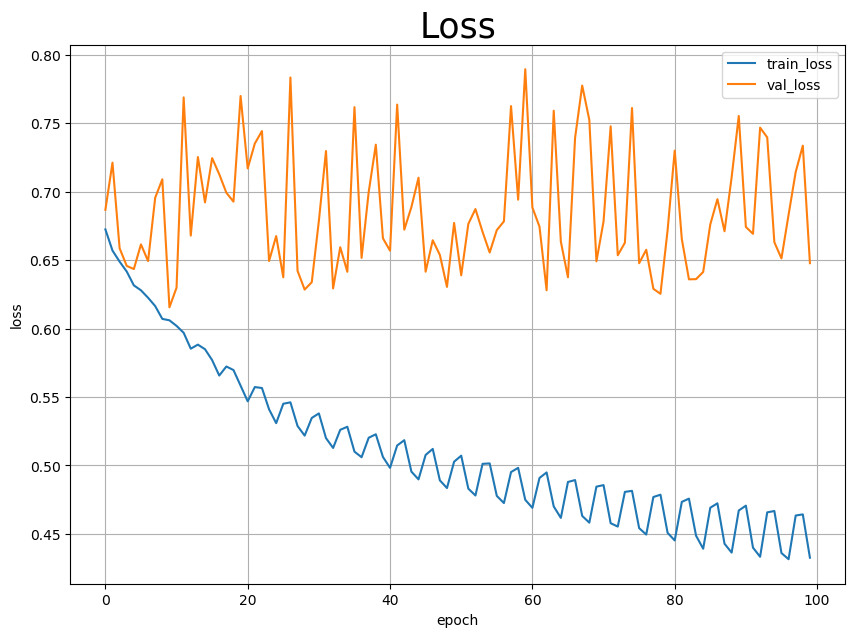

In [25]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

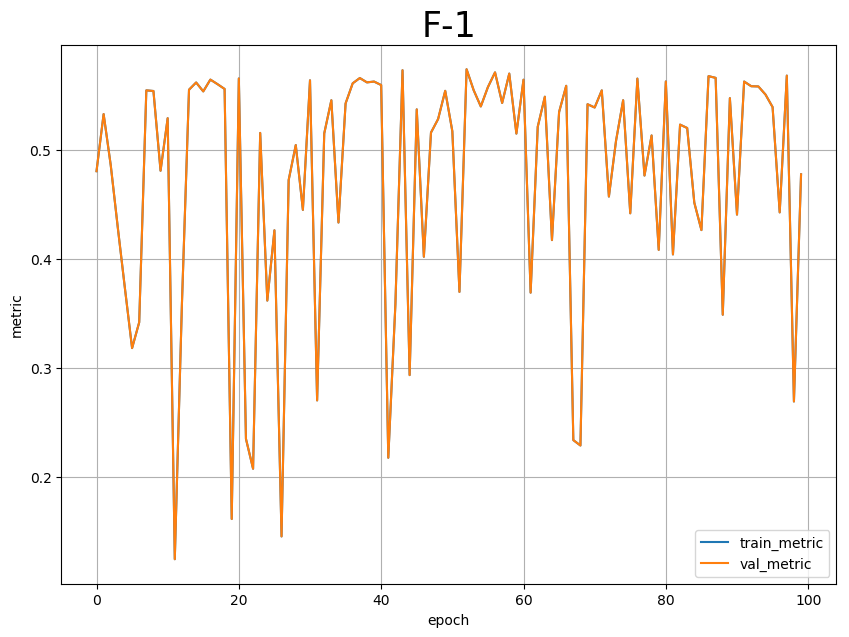

In [26]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [18]:
metric = pd.DataFrame([loss_plot.numpy(), val_loss_plot.numpy(), metric_plot, val_metric_plot]).transpose()
if imbalanced_weight:
    metric.to_csv(resv2_path + r'\metricw.csv')
else:
    metric.to_csv(resv2_path + r'\metric.csv')

# 추론

In [14]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    indices = []
    outputs = []
    preds = []
    labels = []

    for batch, batch_item in tqdm_dataset:

        img = batch_item['img'].to(device)
        # metadata = batch_item['metadata'].to(device)
        label = batch_item['labels']
        indice = batch_item['indices']


        with torch.no_grad():
            output = model(img)
        pred = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        indices.extend(indice)
        outputs.extend(output)
        preds.extend(pred)
        labels.extend(label)
        
    return indices, outputs, preds, labels

# model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
# model.load_state_dict(torch.load(save_path, map_location=device))
# model.to(device)


pr_indices, pr_outputs, pr_preds, pr_labels = predict(te[0])

0it [00:00, ?it/s]C:\Users\Jeyun\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
205it [00:21,  9.33it/s]


In [15]:
# preds = np.array([label_decoder[int(val)] for val in preds])

elapsed_time = datetime.now() - now
now = datetime.now()

print("소요시간: ", elapsed_time)
print("현재: ", now)

소요시간:  0:04:02.472961
현재:  2023-05-02 10:58:25.826659


In [16]:
print(len(pr_preds))
pred_plt = pd.DataFrame([[i.numpy() for i in pr_indices], [i.cpu().numpy()[1] for i in pr_outputs], pr_preds, [i.numpy() for i in pr_labels]], index = ["index", "output", "pred", "label"]).transpose()

pred_plt.set_index("index", inplace=True)
print(pred_plt.iloc[0:1000])
print(pred_plt.pred.mean(), pred_plt.label.mean())
if imbalanced_weight:
    pred_plt.to_csv(resv2_path + r'\pred_pltw.csv')
else:
    pred_plt.to_csv(resv2_path + r'\pred_plt.csv')


52370
             output pred label
index                         
127551  1.05755e-13    0     0
65804    2.1566e-11    0     0
164412   0.00135993    0     0
242979  3.42142e-09    0     0
228357  5.54957e-18    0     0
111734   3.5964e-08    0     0
121639  3.69918e-11    0     0
197907     0.988079    1     0
298614            1    1     1
491859  4.86568e-08    0     0
127542  1.47479e-15    0     0
75455      0.314689    0     0
535509   0.00187287    0     0
5431    2.30117e-08    0     1
93916   8.37269e-05    0     0
141392  1.27703e-22    0     0
335770  2.65112e-16    0     0
378516   0.00729046    0     0
234542  1.99787e-11    0     0
549473  1.09942e-09    0     1
307532  1.09116e-07    0     1
507508   3.1832e-09    0     1
57662   3.53026e-13    0     0
380940  1.22529e-06    0     0
470034  8.17229e-23    0     0
87937   4.47019e-13    0     0
371121  8.91784e-13    0     0
158160    0.0192636    0     0
91181     0.0190851    0     0
330128   0.00826942    0     0
..